In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import os
import re
import copy
import json

In [2]:

from chessboard_utils import *




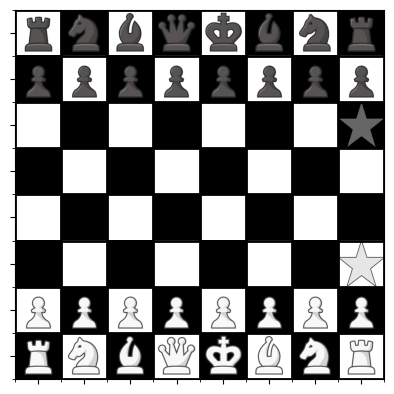

In [3]:
game_state = np.array([
    [-2, -3, -4, -6, -5, -4, -3, -2],
    [-1, -1, -1, -1, -1, -1, -1, -1],
    [ 0,  0,  0,  0,  0,  0,  0,  -7],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  7],
    [ 1,  1,  1,  1,  1,  1,  1,  1],
    [ 2,  3,  4,  6,  5,  4,  3,  2],
])

    
draw_chessboard(game_state, show=True)


In [4]:
from movement_analysis import *

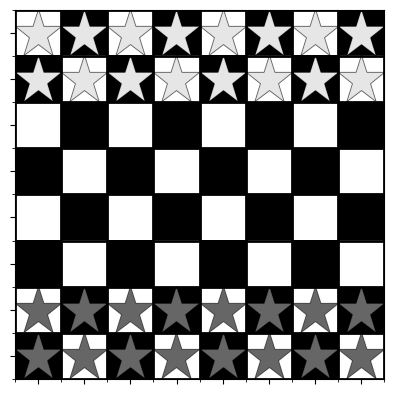


##############################################

Game state 0 (Frame: warped_frame_000100.png):
MOVEMENT ANALYSIS
changes (array([], dtype=int64), array([], dtype=int64))
positions []
Invalid move: No changes detected

##############################################

Game state 1 (Frame: warped_frame_000150.png):
MOVEMENT ANALYSIS
changes (array([], dtype=int64), array([], dtype=int64))
positions []
Invalid move: No changes detected

##############################################

Game state 2 (Frame: warped_frame_000400.png):
MOVEMENT ANALYSIS
changes (array([1, 3], dtype=int64), array([4, 4], dtype=int64))
positions [(1, 4), (3, 4)]
moving_piece 7
initial_final_value 0
VERIFY MOVEMENT
pawn_movements [(2, 4), (3, 4)]
final_pos (3, 4)
pawn move verified
rook_movements [(2, 4), (3, 4), (4, 4), (5, 4), (6, 4)]
rook move verified
knight_movements [(3, 3), (3, 5), (2, 2), (2, 6)]
bishop_movements [(2, 3), (3, 2), (4, 1), (5, 0), (2, 5), (3, 6), (4, 7)]
queen_movements [(2, 4), (3, 4), (4, 4

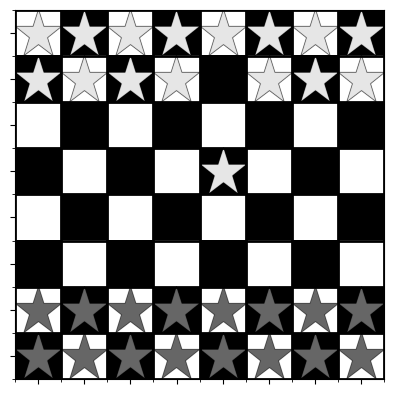

[[ 7  7  7  7  7  7  7  7]
 [ 7  7  7  7  0  7  7  7]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [-7 -7 -7 -7 -7 -7 -7 -7]
 [-7 -7 -7 -7 -7 -7 -7 -7]]

##############################################

Game state 3 (Frame: warped_frame_000450.png):
MOVEMENT ANALYSIS
changes (array([], dtype=int64), array([], dtype=int64))
positions []
Invalid move: No changes detected

##############################################

Game state 4 (Frame: warped_frame_000500.png):
MOVEMENT ANALYSIS
changes (array([], dtype=int64), array([], dtype=int64))
positions []
Invalid move: No changes detected

##############################################

Game state 5 (Frame: warped_frame_000550.png):
MOVEMENT ANALYSIS
changes (array([], dtype=int64), array([], dtype=int64))
positions []
Invalid move: No changes detected

##############################################

Game state 6 (Frame: warped_frame_000600.png):
MOVEMENT ANALYSIS
changes (array(

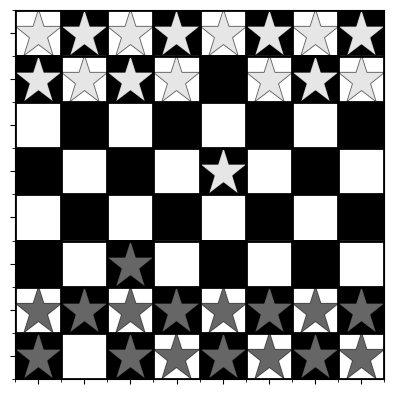

[[ 7  7  7  7  7  7  7  7]
 [ 7  7  7  7  0  7  7  7]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0 -7  0  0  0  0  0]
 [-7 -7 -7 -7 -7 -7 -7 -7]
 [-7  0 -7 -7 -7 -7 -7 -7]]

##############################################

Game state 10 (Frame: warped_frame_001100.png):
MOVEMENT ANALYSIS
changes (array([1, 3], dtype=int64), array([5, 5], dtype=int64))
positions [(1, 5), (3, 5)]
moving_piece 7
initial_final_value 0
VERIFY MOVEMENT
pawn_movements [(2, 5), (3, 5)]
final_pos (3, 5)
pawn move verified
rook_movements [(1, 4), (2, 5), (3, 5), (4, 5), (5, 5), (6, 5)]
rook move verified
knight_movements [(3, 6), (2, 3), (2, 7)]
bishop_movements [(2, 4), (3, 3), (4, 2), (5, 1), (6, 0), (2, 6), (3, 7)]
queen_movements [(1, 4), (2, 5), (3, 5), (4, 5), (5, 5), (6, 5), (2, 4), (3, 3), (4, 2), (5, 1), (6, 0), (2, 6), (3, 7)]
queen move verified
king_movements [(1, 4), (2, 4), (2, 5), (2, 6)]
valid_movements ['pawn', 'rook', 'queen']
Move: f7 -> f5


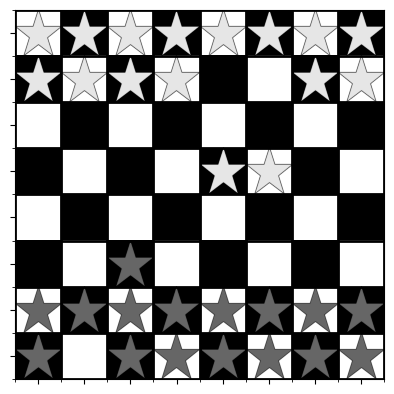

[[ 7  7  7  7  7  7  7  7]
 [ 7  7  7  7  0  0  7  7]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7  7  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0 -7  0  0  0  0  0]
 [-7 -7 -7 -7 -7 -7 -7 -7]
 [-7  0 -7 -7 -7 -7 -7 -7]]

##############################################

Game state 11 (Frame: warped_frame_001150.png):
MOVEMENT ANALYSIS
changes (array([], dtype=int64), array([], dtype=int64))
positions []
Invalid move: No changes detected

##############################################

Game state 12 (Frame: warped_frame_001200.png):
MOVEMENT ANALYSIS
changes (array([], dtype=int64), array([], dtype=int64))
positions []
Invalid move: No changes detected

##############################################

Game state 13 (Frame: warped_frame_001300.png):
MOVEMENT ANALYSIS
changes (array([5, 6], dtype=int64), array([3, 3], dtype=int64))
positions [(5, 3), (6, 3)]
moving_piece -7
initial_final_value 0
VERIFY MOVEMENT
pawn_movements [(5, 3), (4, 3)]
final_pos (5, 3)
pawn move verified
rook_movements [

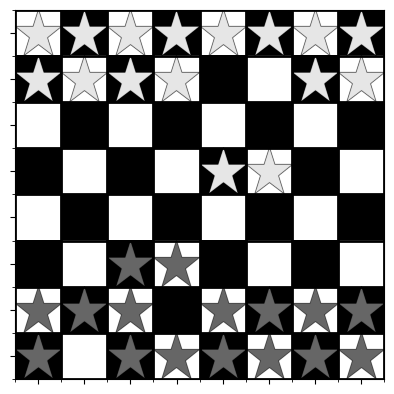

[[ 7  7  7  7  7  7  7  7]
 [ 7  7  7  7  0  0  7  7]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7  7  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0 -7 -7  0  0  0  0]
 [-7 -7 -7  0 -7 -7 -7 -7]
 [-7  0 -7 -7 -7 -7 -7 -7]]

##############################################

Game state 14 (Frame: warped_frame_001400.png):
MOVEMENT ANALYSIS
changes (array([], dtype=int64), array([], dtype=int64))
positions []
Invalid move: No changes detected

##############################################

Game state 15 (Frame: warped_frame_001600.png):
MOVEMENT ANALYSIS
changes (array([0, 2], dtype=int64), array([6, 5], dtype=int64))
positions [(0, 6), (2, 5)]
moving_piece 7
initial_final_value 0
VERIFY MOVEMENT
pawn_movements []
final_pos (2, 5)
rook_movements []
knight_movements [(2, 5), (2, 7), (1, 4)]
knight move verified
bishop_movements [(1, 5), (2, 4), (3, 3), (4, 2), (5, 1), (6, 0)]
queen_movements [(1, 5), (2, 4), (3, 3), (4, 2), (5, 1), (6, 0)]
king_movements [(1, 5)]
valid_movements ['knight']
Move: 

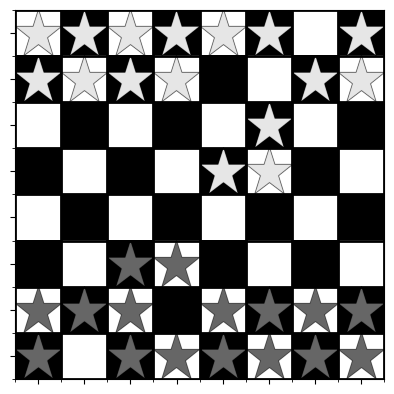

[[ 7  7  7  7  7  7  0  7]
 [ 7  7  7  7  0  0  7  7]
 [ 0  0  0  0  0  7  0  0]
 [ 0  0  0  0  7  7  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0 -7 -7  0  0  0  0]
 [-7 -7 -7  0 -7 -7 -7 -7]
 [-7  0 -7 -7 -7 -7 -7 -7]]

##############################################

Game state 16 (Frame: warped_frame_001700.png):
MOVEMENT ANALYSIS
changes (array([], dtype=int64), array([], dtype=int64))
positions []
Invalid move: No changes detected

##############################################

Game state 17 (Frame: warped_frame_001800.png):
MOVEMENT ANALYSIS
changes (array([], dtype=int64), array([], dtype=int64))
positions []
Invalid move: No changes detected

##############################################

Game state 18 (Frame: warped_frame_002100.png):
MOVEMENT ANALYSIS
changes (array([3, 6, 7], dtype=int64), array([6, 5, 2], dtype=int64))
positions [(3, 6), (6, 5), (7, 2)]
Invalid move: Invalid number of position changes

##############################################

Game state 19 (Frame: warp

In [5]:


# Read the game states from game_state.json
with open('game_state.json', 'r') as f:
    game_data = json.load(f)


last_game_state = game_data['game_states'][0]['gs']

draw_chessboard(last_game_state, show=True)


# Display each game state
for i, state in enumerate(game_data['game_states'][1:]):

    print('\n##############################################')
    print(f"\nGame state {i} (Frame: {state['frame']}):")

    

    valid_move = True

    
    curr_state = np.array(state['gs'])
    move_analysis = analyze_move(last_game_state, curr_state)

    valid_move = move_analysis['valid']
    
    if move_analysis['valid']:
        from_pos = move_analysis['from_pos']
        to_pos = move_analysis['to_pos']
        piece = move_analysis['piece']
        
        # Convertir les positions en notation d'échecs
        from_square = f"{chr(97 + from_pos[1])}{8 - from_pos[0]}"
        to_square = f"{chr(97 + to_pos[1])}{8 - to_pos[0]}"
        
        if move_analysis['move_type'] == 'move':
            print(f"Move: {from_square} -> {to_square}")
        else:  # capture
            print(f"Capture: {from_square} x {to_square}")

        draw_chessboard(curr_state, show=True)
        print(curr_state)

        last_game_state = curr_state
    else:
        print(f"Invalid move: {move_analysis['message']}")

    
    


    
    
    
    
